In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

/Users/jteruya/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Matlab Plot Settings

In [2]:
# Display Plot within Jupyter Notebook
%matplotlib inline
# Default Plot Size
plt.rcParams['figure.figsize'] = [10, 10]

## Index Data

In [3]:
# Helper Function
def download_data(ticker, start, end):
    return yf.download(ticker, start, end)

# Start and End Dates for Ticker Data
start_date = "2018-01-01"
end_date = "2020-12-17"
# List of Indices to Retrieve Data
indices = ["^VIX", "^GSPC", "^DJI"]
# List of lists
indices_data = [download_data(index, start_date, end_date) for index in indices]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Percent Movement Per Index
Calculate the % change for each day

In [4]:
# Percent Movement Helper Function
def market_movement(row):
    return (row['Close'] - row['Open'])/row['Open']

# Apply helper function to all index dataframes
percent_movement = [index.apply(market_movement, axis=1) for index in indices_data]

## Visualize Percent Market Per Day

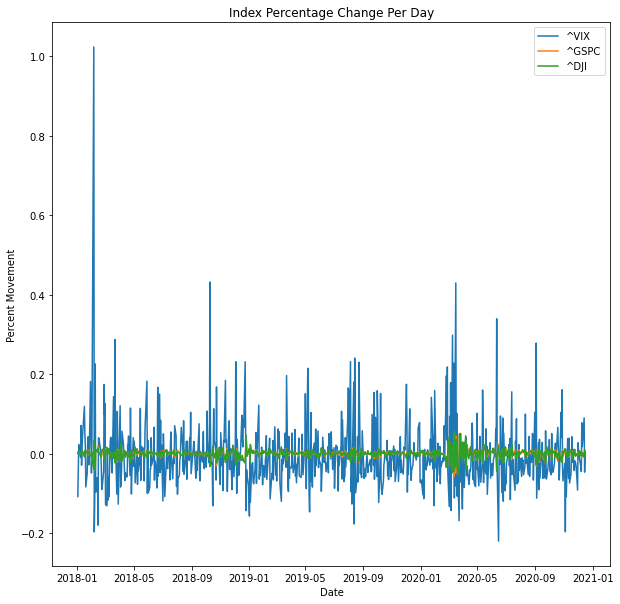

In [5]:
for x in range(len(indices)):
    plt.plot(percent_movement[x], label=indices[x])
plt.xlabel('Date')
plt.ylabel('Percent Movement')
plt.title('Index Percentage Change Per Day')
plt.legend()
plt.show()

## Daily Correlations

In [6]:
# Inital Correlation Dataframe
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
original_columns = all_indices_df.columns

# Add Timeshifts (by Day)
max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

# Correlations on Columns
all_indices_df.corr(method ='pearson')

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,VIX Percent Movement + 1 Day Shift,GSPC Percent Movement + 1 Day Shift,DJI Percent Movement + 1 Day Shift,VIX Percent Movement + 2 Day Shift,GSPC Percent Movement + 2 Day Shift,DJI Percent Movement + 2 Day Shift,VIX Percent Movement + 3 Day Shift,GSPC Percent Movement + 3 Day Shift,DJI Percent Movement + 3 Day Shift
VIX Percent Movement,1.000000,-0.662269,-0.634751,-0.034284,0.131184,0.119160,0.020774,-0.064095,-0.073387,0.026558,-0.097968,-0.077665
GSPC Percent Movement,-0.662269,1.000000,0.959953,0.119297,-0.202666,-0.197618,-0.045891,0.078552,0.087418,0.004561,-0.006436,-0.039070
DJI Percent Movement,-0.634751,0.959953,1.000000,0.109857,-0.181270,-0.185698,-0.037533,0.073608,0.080999,0.001779,0.001061,-0.037303
VIX Percent Movement + 1 Day Shift,-0.034284,0.119297,0.109857,1.000000,-0.662315,-0.635302,-0.035086,0.132224,0.119724,0.021315,-0.063895,-0.072803
GSPC Percent Movement + 1 Day Shift,0.131184,-0.202666,-0.181270,-0.662315,1.000000,0.960041,0.119594,-0.203037,-0.197804,-0.046081,0.078471,0.087206
DJI Percent Movement + 1 Day Shift,0.119160,-0.197618,-0.185698,-0.635302,0.960041,1.000000,0.109906,-0.181344,-0.185727,-0.037559,0.073597,0.080978
VIX Percent Movement + 2 Day Shift,0.020774,-0.045891,-0.037533,-0.035086,0.119594,0.109906,1.000000,-0.662205,-0.635258,-0.034897,0.132346,0.120006
GSPC Percent Movement + 2 Day Shift,-0.064095,0.078552,0.073608,0.132224,-0.203037,-0.181344,-0.662205,1.000000,0.960081,0.119399,-0.203196,-0.198156
DJI Percent Movement + 2 Day Shift,-0.073387,0.087418,0.080999,0.119724,-0.197804,-0.185727,-0.635258,0.960081,1.000000,0.109806,-0.181414,-0.185901
VIX Percent Movement + 3 Day Shift,0.026558,0.004561,0.001779,0.021315,-0.046081,-0.037559,-0.034897,0.119399,0.109806,1.000000,-0.662329,-0.635542


## Monthly Correlations

In [7]:
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
all_indices_df['Month'] = all_indices_df.index.year * 100 + all_indices_df.index.month

months = all_indices_df['Month'].unique().tolist()

max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

all_indices_df = all_indices_df.groupby(['Month']).corr(method ='pearson')

vix = []
dji = []
vix_1 = []
dji_1 = []
vix_2 = []
dji_2 = []
vix_3 = []
dji_3 = []

for month in months:
    monthly_indices_df = all_indices_df.loc[month, "GSPC Percent Movement"]
    vix.append(monthly_indices_df['VIX Percent Movement'])
    dji.append(monthly_indices_df['DJI Percent Movement'])
    vix_1.append(monthly_indices_df['VIX Percent Movement + 1 Day Shift'])
    dji_1.append(monthly_indices_df['DJI Percent Movement + 1 Day Shift'])
    vix_2.append(monthly_indices_df['VIX Percent Movement + 2 Day Shift'])
    dji_2.append(monthly_indices_df['DJI Percent Movement + 2 Day Shift'])
    vix_3.append(monthly_indices_df['VIX Percent Movement + 3 Day Shift'])
    dji_3.append(monthly_indices_df['DJI Percent Movement + 3 Day Shift'])
    
monthly_data = {'MONTH': [datetime.strptime(str(month), '%Y%m') for month in months], 'VIX': vix, 'DOW': dji, 'VIX+1': vix_1, 'DJI+1': dji_1, 'VIX+2': vix_2, 'DJI+2': dji_2, 'VIX+3': vix_3, 'DJI+3': dji_3}
monthly_df = pd.DataFrame(data = monthly_data).set_index('MONTH')
monthly_df


,VIX,DOW,VIX+1,DJI+1,VIX+2,DJI+2,VIX+3,DJI+3
MONTH,,,,,,,,
2018-01-01,-0.565359,0.860012,0.317682,-0.293251,-0.054204,0.226206,-0.325202,0.316712
2018-02-01,-0.757415,0.987170,-0.138880,-0.005986,0.288273,-0.466581,-0.060092,0.172896
2018-03-01,-0.859288,0.961689,0.177361,-0.155674,0.067747,-0.077555,-0.530501,0.374212
2018-04-01,-0.800092,0.976117,-0.049803,0.060709,0.271888,-0.453093,0.237156,-0.262256
2018-05-01,-0.698296,0.889919,0.067769,-0.195455,0.148382,-0.043065,0.084612,0.084648
2018-06-01,-0.814000,0.848683,0.145764,-0.172423,-0.384982,0.430915,0.368345,-0.277038
2018-07-01,-0.765313,0.798135,0.114160,0.129619,0.533952,-0.004068,-0.018604,-0.238733
2018-08-01,-0.773935,0.776297,0.202197,-0.014369,-0.265836,0.147262,0.090121,-0.234086
2018-09-01,-0.685961,0.738873,-0.090018,0.076854,0.229176,0.112778,0.080186,-0.212138


## Plot Monthly Correlations over Time for SP500

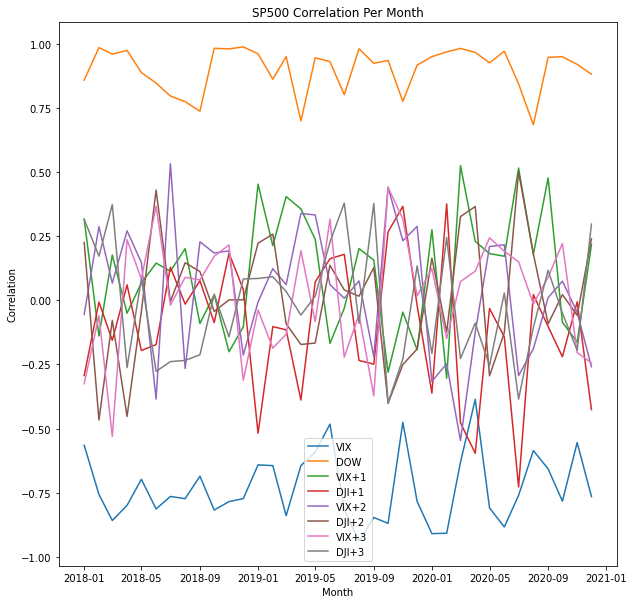

In [8]:
for x in range(len(monthly_df.columns)):
    plt.plot(monthly_df[monthly_df.columns[x]], label=monthly_df.columns[x])
plt.xlabel('Month')
plt.ylabel('Correlation')
plt.title('SP500 Correlation Per Month')
plt.legend()
plt.show()